## Phase estimation algorithm

Author: Andrés Gómez

Let be U an unitary operation such that

$$U|v\rangle = e^{2\pi\theta i}|v\rangle$$

i.e., $|v\rangle$ is an eigenvector of $U$, being $e^{2\pi\theta i}$ its eigenvalue. The objective of this algorithm is to find $\theta$ with enough accuracy.


For this unitary, one can see that $U^m|v\rangle = e^{2\pi\theta m i}|v\rangle$ because

$$U^m|v\rangle = U^{m-1}U|v\rangle= e^{2\pi\theta i}U^{m-1}|v\rangle = e^{2\pi\theta i} e^{2\pi\theta i} U^{m-2}|v\rangle=\dots =e^{2\pi\theta i} e^{2\pi\theta i}\dots e^{2\pi\theta i}|u\rangle=e^{2\pi m \theta i}|u\rangle$$

Also, the control-U gate can be defined as:

$$CU=|0\rangle\langle0|\otimes I + |1\rangle\langle1|\otimes U$$

Applying it to a state 

$$|\phi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)\otimes |v\rangle$$

the result is:

$$CU|\phi\rangle = (|0\rangle\langle0|\otimes I + |1\rangle\langle1|\otimes U)(\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)\otimes |v\rangle)=
(|0\rangle\langle0|\otimes I)(\frac{1}{\sqrt{2}}|0\rangle \otimes |v\rangle) + (|1\rangle\langle1|\otimes U)(\frac{1}{\sqrt{2}}|1\rangle \otimes |v\rangle)=
\frac{1}{\sqrt{2}}|0\rangle\langle0|0\rangle\otimes I|v\rangle+\frac{1}{\sqrt{2}}|1\rangle\langle1|1\rangle\otimes U|v\rangle = \frac{1}{\sqrt{2}} (|0\rangle\otimes |v\rangle+ |1\rangle \otimes e^{2\pi\theta i}|u\rangle)=
\frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi\theta i} |1\rangle)\otimes |v\rangle$$

Similarly, it is possible to define the control of a power of U

$$CU^m|\phi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi m\theta i} |1\rangle)\otimes |v\rangle$$

If the control qubit is $j$ ($C^jU^m$), this phase is raised to the $j$ qubit. So:

$$C^{2^n-1}U^{2^{n-1}}\dots C^{2^0-1}U^{2^{0}}(H^{\otimes}|0\rangle\otimes|v\rangle)=\\
\frac{1}{2^{\frac{n}{2}}} [(|0>+e^{2\pi 2^{n-1} \theta i}|1\rangle) \otimes(|0>+e^{2\pi 2^{n-2} \theta i}|1\rangle)\otimes \dots (|0>+e^{2\pi 2^{0} \theta i}|1\rangle) \otimes |v\rangle=  \frac{1}{2^{\frac{n}{2}}}\sum_{k=0}^{2^n-1} e^{2\pi k \theta i}|k\rangle\otimes|v\rangle$$

so, applying the inverse of the QFT to the first qubits, it is possible to get an approximation of the angle $\theta$ up to an accuracy of $\frac{1}{2^n}$, being $n$ the number of qubits of the first register which controls the unitary operation.







In [1]:
import numpy as np
import math
from qiskit import BasicAer, QuantumCircuit, QuantumRegister,ClassicalRegister,transpile
from qiskit.aqua import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua.components.iqfts import Standard


Define the unitary operator

$$U=\begin{pmatrix}e^{2\pi j\phi_1} & 0 \\ 0 & e^{2\pi j\phi_2}\end{pmatrix}$$

with $\phi_1,\phi_2 <1$

In [2]:
phi1=2/32
phi2=8/32
import cmath
U=np.array([[cmath.exp(2.j*np.pi*phi1),0],[0,cmath.exp(2.j*np.pi*phi2)]])


In [3]:
from qiskit.extensions.unitary import UnitaryGate

In [4]:
CU=UnitaryGate(U,label="U").control(1)
CU.to_matrix()

array([[1.00000000e+00+0.j        , 0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , 0.00000000e+00+0.j        ],
       [0.00000000e+00+0.j        , 9.23879533e-01+0.38268343j,
        0.00000000e+00+0.j        , 0.00000000e+00+0.j        ],
       [0.00000000e+00+0.j        , 0.00000000e+00+0.j        ,
        1.00000000e+00+0.j        , 0.00000000e+00+0.j        ],
       [0.00000000e+00+0.j        , 0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , 6.12323400e-17+1.j        ]])

Be careful, when the controlled unitary U is added, the first qubit is the control qubit and the second the target qubit. So, the instruction is

*qc.append(CU,[control,target])*

This is equivalent to say that, for the case of Qiskit, 

$$CU=U\otimes|1\rangle\langle1|+I\otimes|0\rangle\langle0|$$

So, if $U=X$, the CX will be

$$CX=X\otimes|1\rangle\langle1| + I\otimes|0\rangle\langle0|=\begin{pmatrix}0 & 1\\ 1 & 0\end{pmatrix}\otimes\begin{pmatrix}0 & 0\\ 0 & 1\end{pmatrix}+\begin{pmatrix}1& 0\\ 0 & 1\end{pmatrix}\otimes\begin{pmatrix}1 & 0\\ 0 & 0\end{pmatrix}=\begin{pmatrix}0& 0&0&0\\0& 0&0&1  \\0& 0&0&0\\0& 1&0&0\end{pmatrix}+
\begin{pmatrix}1& 0&0&0\\0& 0&0&0  \\0& 0&1&0\\0& 0&0&0\end{pmatrix}=\begin{pmatrix}1& 0&0&0\\0& 0&0&1  \\0& 0&1&0\\0& 1&0&0\end{pmatrix}
$$


In [5]:
CX=UnitaryGate(np.array([[0,1],[1,0]]),label="CX").control(1)
CX.to_matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

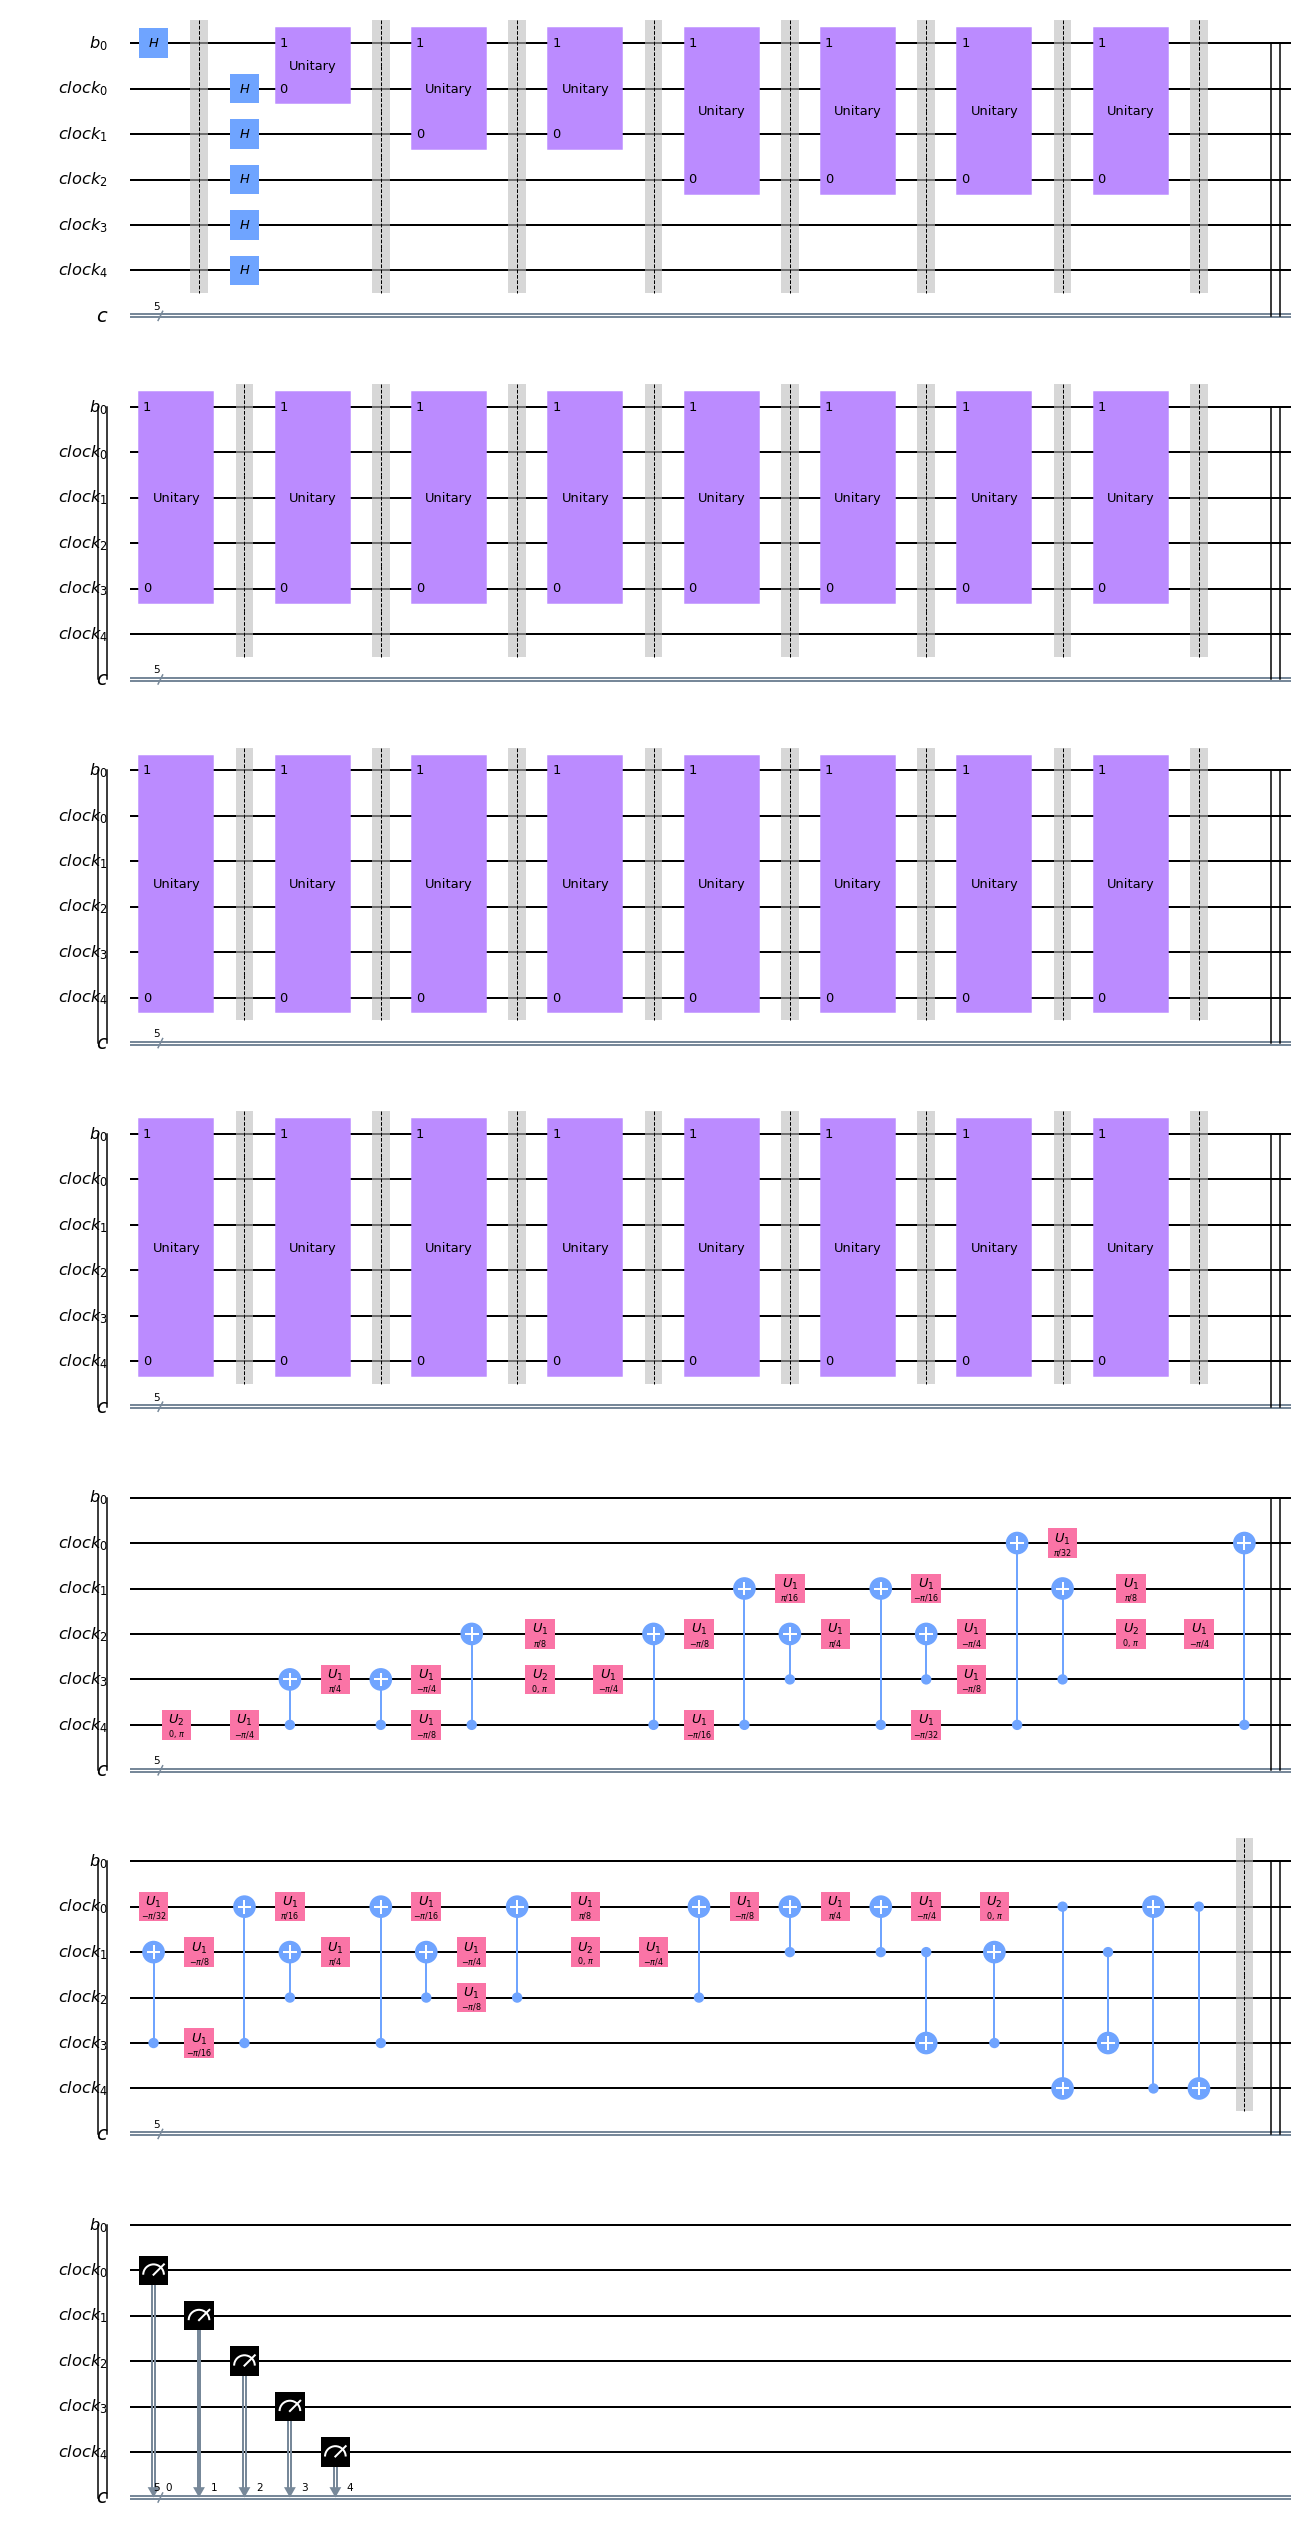

In [6]:
accuracy=5
C=QuantumRegister(accuracy,name="clock")
b=QuantumRegister(1,name="b")
sol=ClassicalRegister(accuracy,name="c")
qc=QuantumCircuit(b,C,sol,name="QPE")
qc.h(b)
qc.barrier()
qc.h(C)

for i in range(len(C)):
    for j in range(2**i):
        qc.append(CU,[C[i],b])
        qc.barrier()
    
iqft = Standard(accuracy)
iqft.construct_circuit(mode="circuit",circuit=qc,qubits=C,do_swaps=True)
qc.barrier()
qc.measure(C,sol)
qc.draw(output="mpl")

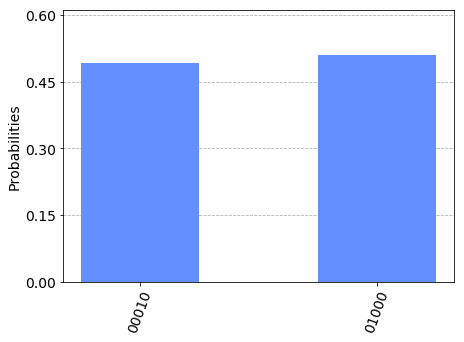

In [7]:
backend = BasicAer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, shots=1000)
results=quantum_instance.execute(qc)

plot_histogram(results.get_counts(qc),bar_labels=False)

In [8]:
print(results.get_counts(qc))
print(11/2**5)
print(phi2)
print(10/2**5)


{'00010': 491, '01000': 509}
0.34375
0.25
0.3125


In [9]:
b=QuantumRegister(2,name="b")
sol=ClassicalRegister(2,name="c")
qc=QuantumCircuit(b,sol,name="QPE")
qc.x(b[0])

qc.append(UnitaryGate(U,label="U").control(1),[b[0],b[1]])

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)
results=quantum_instance.execute(qc)

results.get_statevector()
qc.draw()